In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
folder_path ='/content/drive/MyDrive/https://drive.google.com/drive/folders/1_OtZ3VPV8S5H9Pe179o7MyQBF3_W68AI?usp=drive_link'

In [25]:
#dependencies
!pip install biopython

Textarea(value='', description='Query Seq:', layout=Layout(height='100px', width='100%'), placeholder='Paste y…

Button(button_style='success', description='Enter', style=ButtonStyle())

Button(button_style='info', description='Run Example Input', style=ButtonStyle())

Output()

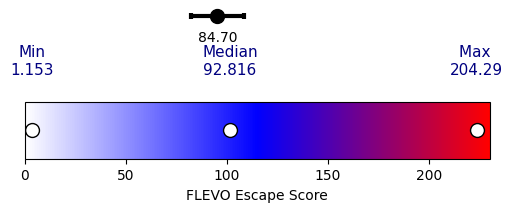

In [36]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from Bio.Seq import Seq
from Bio import SeqIO
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

# Load FLEVO escape scores
evescape_df = pd.read_csv("prrsv_scaled_flevo_scores.csv")
evescape_df["mutations"] = evescape_df["wt"] + evescape_df["i"].astype(str) + evescape_df["mut"]
evescape_dict_pos = dict(zip(evescape_df["mutations"], evescape_df["evescape"] - evescape_df["evescape"].min()))
evescape_dict_sigmoid = dict(zip(evescape_df["mutations"], evescape_df["evescape"].apply(lambda x: 1 / (1 + math.exp(-x)))))

# Reference sequence
ref_aa_seq = "MLEKCLTAGYCSQLLFFWCIVPFCFAALVNAASNSSSHLQLIYNLTICELNGTDWLNQKFDWAVETFVIFPVLTHIVSYGALTTSHFLDTAGLITVSTAGYYHGRYVLSSIYAVFALAALICFVIRLTKNCMSWRYSCTRYTNFLLDTKGNLYRWRSPVVIERRGKVEVGDHLIDLKRVVLDGSAATPITKISAEQWGRP"

# Widgets
query_input = widgets.Textarea(
    value='',
    placeholder='Paste your ORF5 GP5 amino acid sequence (200 aa)',
    description='Query Seq:',
    layout=widgets.Layout(width='100%', height='100px')
)

enter_button = widgets.Button(description="Enter", button_style='success')
example_button = widgets.Button(description="Run Example Input", button_style='info')
output_area = widgets.Output()

# Example sequence (must be 200 aa)
example_sequence = "MLGKCLTAGCCSQLPFLWCIVPFCFVALVNASNNSSSHLQLIYNLTICELNGTDWLNKSFDWAVETFVIFPVLTHIVSYGALTTSHFLDTVGLITVSAAGYYHGRYVLSSIYAVCALAALTCFVIRLTKNCMSWRYSCTRYTNFLQDTKGKLYRWRSPVIIEKGGKIEVEGHLIDLKRVVLDGSAATPVTKVSAEQWGRP"
def on_enter_clicked(b):
    output_area.clear_output(wait=True)
    with output_area:
        query_seq_input = query_input.value.strip().upper()
        if len(query_seq_input) != 200:
            print("❌ Please enter a 200-length amino acid sequence.")
            return

        def hamming_distance(seq1, seq2):
            if len(seq1) != len(seq2):
                return None
            return sum(a != b for a, b in zip(seq1, seq2))

        query_seq = Seq(query_seq_input)
        hdist = hamming_distance(ref_aa_seq, query_seq)
        print(f"Hamming distance from WT: {hdist}")

        mutations = []
        for i in range(len(ref_aa_seq)):
            ref_aa = ref_aa_seq[i]
            query_aa = query_seq[i]
            if ref_aa in ["*", "X"] or query_aa in ["*", "X", "-"]:
                continue
            if ref_aa != query_aa:
                mut_string = f"{ref_aa}{i+1}{query_aa}"
                if mut_string in evescape_dict_pos:
                    mutations.append(mut_string)

        score_pos = sum(evescape_dict_pos.get(m, 0) for m in mutations)
        score_sigmoid = sum(evescape_dict_sigmoid.get(m, 0) for m in mutations)
        print(f"FLEVO escape score: {score_pos:.3f}")

        if hdist > 100:
            print("This sequence is likely not that of PRRSV GP5")
            uncertainty = 100
        else:
            uncertainty = (hdist / 200) * 100
        print(f"Uncertainty: {uncertainty:.3f}%")

        minimum = 1.1572728000000003
        maximum = 204.29259040000005
        mean = 92.8164662
        diff_sig_min = abs(score_pos - minimum)
        diff_sig_mean = abs(score_pos - mean)
        diff_sig_max = abs(maximum - score_pos)

        position_mean = (
            "above median" if score_pos > mean else
            "equal to median" if score_pos == mean else
            "below median"
        )
        print(f"- Relative score from minimum escape mutant: {diff_sig_min:.3f}")
        print(f"- Relative score from median escape mutant: {diff_sig_mean:.3f} ({position_mean})")
        print(f"- Relative score from maximum escape mutant: {diff_sig_max:.3f}")

        critical_points = [204.29, 92.816, 3.253]
        critical_labels = ['Max \n204.29', 'Median\n92.816', 'Min\n1.153']

        def plot_colorbar_with_point_and_uncertainty(min_val, max_val, point_val, mean_val,
                                                     label="FLEVO Escape Score", whisker_scale=1, uncertainty=0.5):
            whisker_length = uncertainty / 100
            fig, ax = plt.subplots(figsize=(6, 1.5))
            fig.subplots_adjust(bottom=0.5)

            colors = [(1, 1, 1), (0, 0, 1), (1, 0, 0)]
            cmap = mpl.colors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
            norm = mpl.colors.Normalize(vmin=0, vmax=230)

            cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
            cb.set_label(label)

            point_position = (point_val - 0) / (max_val - 0)

            ax.plot(point_position, 2.5, marker='o', markersize=10,
                    markerfacecolor='black', markeredgecolor='black', transform=ax.transAxes, clip_on=False)
            ax.text(point_position, 2.0, f"{point_val:.2f}", color='black', ha='center', va='bottom', transform=ax.transAxes)

            ax.hlines(y=2.5,
                      xmin=point_position - whisker_length / 2,
                      xmax=point_position + whisker_length / 2,
                      color='black', linewidth=3,
                      transform=ax.transAxes, clip_on=False)

            ax.vlines(x=[point_position - whisker_length / 2, point_position + whisker_length / 2],
                      ymin=2.45, ymax=2.55,
                      color='black', linewidth=3,
                      transform=ax.transAxes, clip_on=False)

            for rp, rl in zip(critical_points, critical_labels):
                xpos = rp / 210
                y_random = 0.5
                ax.plot(xpos, y_random, marker='o', markersize=10,
                        markerfacecolor='white', markeredgecolor='black', linewidth=1.5, transform=ax.transAxes)
                ax.text(xpos, y_random + 1.5, rl, ha='center', va='top', fontsize=11, color='navy', transform=ax.transAxes)

        # Find closest match in database
        min_distance = None
        closest_match_id = None
        for record in SeqIO.parse("database.fasta", "fasta"):
            seq = str(record.seq)
            distance = hamming_distance(seq, query_seq)
            if distance is not None and (min_distance is None or distance < min_distance):
                min_distance = distance
                closest_match_id = record.id

        if closest_match_id:
            parts = closest_match_id.split('|')
            seq_id = parts[0]
            date = parts[1] if len(parts) > 1 else "Unknown"
            similarity = (1 - min_distance / 200) * 100
            print(f"Closest match ID: {seq_id}")
            print(f"Date: {date}")
            print(f"Similarity: {similarity:.3f}%")

        plot_colorbar_with_point_and_uncertainty(minimum, maximum, score_pos, mean, uncertainty=uncertainty)

# Example button logic
def on_example_clicked(b):
    query_input.value = example_sequence
    on_enter_clicked(b)

# Link buttons to functions
enter_button.on_click(on_enter_clicked)
example_button.on_click(on_example_clicked)

# Display interface
display(query_input, enter_button, example_button, output_area)


In [32]:
import pandas as pd
import math
from Bio.Seq import Seq
from Bio import SeqIO

# Load FLEVO escape scores
evescape_df = pd.read_csv("prrsv_scaled_flevo_scores.csv")
evescape_df["mutations"] = evescape_df["wt"] + evescape_df["i"].astype(str) + evescape_df["mut"]
evescape_dict_pos = dict(zip(evescape_df["mutations"], evescape_df["evescape"] - evescape_df["evescape"].min()))
evescape_dict_sigmoid = dict(zip(evescape_df["mutations"], evescape_df["evescape"].apply(lambda x: 1 / (1 + math.exp(-x)))))

# Reference sequence
ref_aa_seq = "MLEKCLTAGYCSQLLFFWCIVPFCFAALVNAASNSSSHLQLIYNLTICELNGTDWLNQKFDWAVETFVIFPVLTHIVSYGALTTSHFLDTAGLITVSTAGYYHGRYVLSSIYAVFALAALICFVIRLTKNCMSWRYSCTRYTNFLLDTKGNLYRWRSPVVIERRGKVEVGDHLIDLKRVVLDGSAATPITKISAEQWGRP"

# Function to calculate Hamming distance
def hamming_distance(seq1, seq2):
    if len(seq1) != len(seq2):
        return None
    return sum(a != b for a, b in zip(seq1, seq2))

# Load batch input CSV
batch_df = pd.read_csv("test.csv", header=None, names=["ID", "Sequence"])

# Prepare output list
output_data = []

# Process each sequence
for index, row in batch_df.iterrows():
    seq_id = row["ID"]
    query_seq_input = row["Sequence"].strip().upper()

    if len(query_seq_input) != 200:
        output_data.append([seq_id, "Invalid sequence length", "", "", "", "", "", "", "", ""])
        continue

    query_seq = Seq(query_seq_input)
    hdist = hamming_distance(ref_aa_seq, query_seq)

    mutations = []
    for i in range(len(ref_aa_seq)):
        ref_aa = ref_aa_seq[i]
        query_aa = query_seq[i]
        if ref_aa in ["*", "X"] or query_aa in ["*", "X", "-"]:
            continue
        if ref_aa != query_aa:
            mut_string = f"{ref_aa}{i+1}{query_aa}"
            if mut_string in evescape_dict_pos:
                mutations.append(mut_string)

    score_pos = sum(evescape_dict_pos.get(m, 0) for m in mutations)
    score_sigmoid = sum(evescape_dict_sigmoid.get(m, 0) for m in mutations)

    uncertainty = 100 if hdist > 30 else (hdist / 200) * 100

    minimum = 1.1572728000000003
    maximum = 204.29259040000005
    mean = 92.8164662
    diff_sig_min = abs(score_pos - minimum)
    diff_sig_mean = abs(score_pos - mean)
    diff_sig_max = abs(maximum - score_pos)

    position_mean = (
        "above median" if score_pos > mean else
        "equal to median" if score_pos == mean else
        "below median"
    )

    # Find closest match in database
    min_distance = None
    closest_match_id = None
    for record in SeqIO.parse("database.fasta", "fasta"):
        seq = str(record.seq)
        distance = hamming_distance(seq, query_seq)
        if distance is not None and (min_distance is None or distance < min_distance):
            min_distance = distance
            closest_match_id = record.id

    if closest_match_id:
        parts = closest_match_id.split('|')
        match_id = parts[0]
        match_date = parts[1] if len(parts) > 1 else "Unknown"
        similarity = (1 - min_distance / 200) * 100
    else:
        match_id = "None"
        match_date = "None"
        similarity = "None"

    output_data.append([
        seq_id, hdist, score_pos, uncertainty,
        diff_sig_min, diff_sig_mean, position_mean, diff_sig_max,
        match_id, match_date, similarity
    ])

# Save results to CSV
output_df = pd.DataFrame(output_data, columns=[
    "ID", "Hamming Distance", "FLEVO Escape Score", "Uncertainty (%)",
    "Distance from Min", "Distance from Median", "Position vs Median",
    "Distance from Max", "Closest Match ID", "Date", "Similarity (%)"
])
output_df.to_csv("flevo_output.csv", index=False)
print("Batch processing complete. Results saved to flevo_output.csv.")


Batch processing complete. Results saved to output.csv.
